<a href="https://colab.research.google.com/github/aromanenko/ATSF/blob/wip/ts_long%20ts_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers for the long-term time series forecasting

### 1. Dataset: Electricity Transformer Temperature

The Electricity Transformer Temperature (ETT) is a crucial indicator in the electric power long-term deployment. This dataset consists of 2 years data from two separated counties in China. Each data point consists of 8 features, including the date of the point, the predictive value "oil temperature", and 6 different types of external power load features.

In [ ]:
!pip install transformers

In [ ]:
!git clone https://github.com/zhouhaoyi/ETDataset.git

Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 25), reused 20 (delta 20), pack-reused 159 (from 1)
Receiving objects: 100% (187/187), 3.86 MiB | 6.69 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import argparse
import warnings

from sklearn.preprocessing import StandardScaler

from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
import torch
pd.options.plotting.backend = "plotly"

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# data = pd.read_csv('ETDataset/ETT-small/ETTh1.csv')
ech_df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption_hours.csv', sep=',', parse_dates=['Date'], dayfirst=False)
ech_df.tail(10)

,Date,EnergyCons,Dev,WeekDay
26270,2007-12-31 14:00:00,1976,-13,1
26271,2007-12-31 15:00:00,1968,-14,1
26272,2007-12-31 16:00:00,1914,-14,1
26273,2007-12-31 17:00:00,1859,-13,1
26274,2007-12-31 18:00:00,1830,-13,1
26275,2007-12-31 19:00:00,1719,-13,1
26276,2007-12-31 20:00:00,1621,-12,1
26277,2007-12-31 21:00:00,1516,-12,1
26278,2007-12-31 22:00:00,1459,-11,1
26279,2007-12-31 23:00:00,1406,-11,1


In [ ]:
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [ ]:
ech_df.shape

(26280, 3)

In [ ]:
# plt.figure(figsize=(8, 4))
# plt.plot(data['OT'], color='darkblue');
ech_df.set_index('Date')['EnergyCons'].plot()

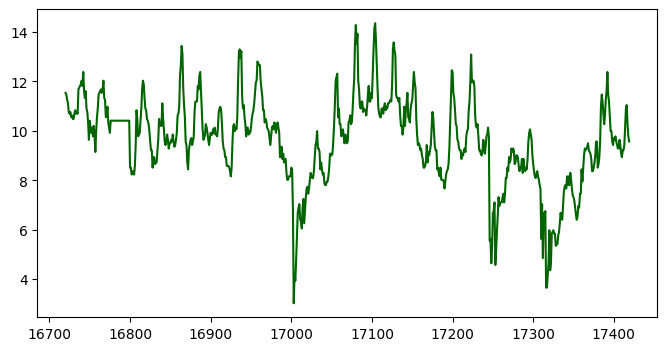

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(data['OT'].iloc[-700:], color='darkgreen');

#2. Transformer-based models: Informer, Autoformer, FEDformer

# Vanilla Transformer

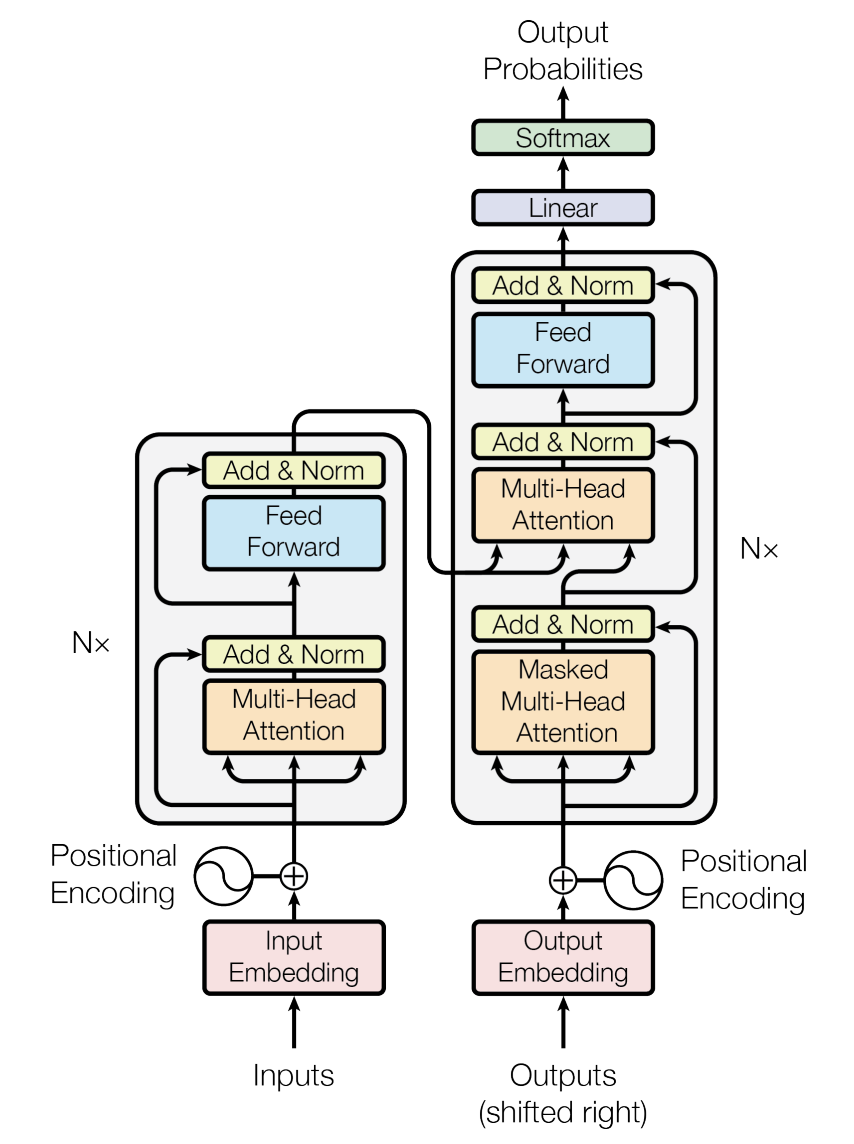

The drawback of vanilla Transformer:

- **Quadratic computation of canonical self-attention**
The vanilla Transformer has a computational complexity of $O(L^2D)$, where L is the time series length and D is the dimension of the hidden states. For long sequence time-series forecasting (also known as the LSTF problem), this might be really computationally expensive. To solve this problem, Informer employs a new self-attention mechanism called ProbSparse attention, which has $O(LlogL)$ time and space complexity.

- **Memory bottleneck when stacking layers**
When stacking N encoder/decoder layers, the vanilla Transformer has a memory usage of $O(NL^2)$, which limits the model's capacity for long sequences. Informer uses a Distilling operation, for reducing the input size between layers into its half slice. By doing so, it reduces the whole memory usage to be $O(N⋅LlogL)$.

# Informer model

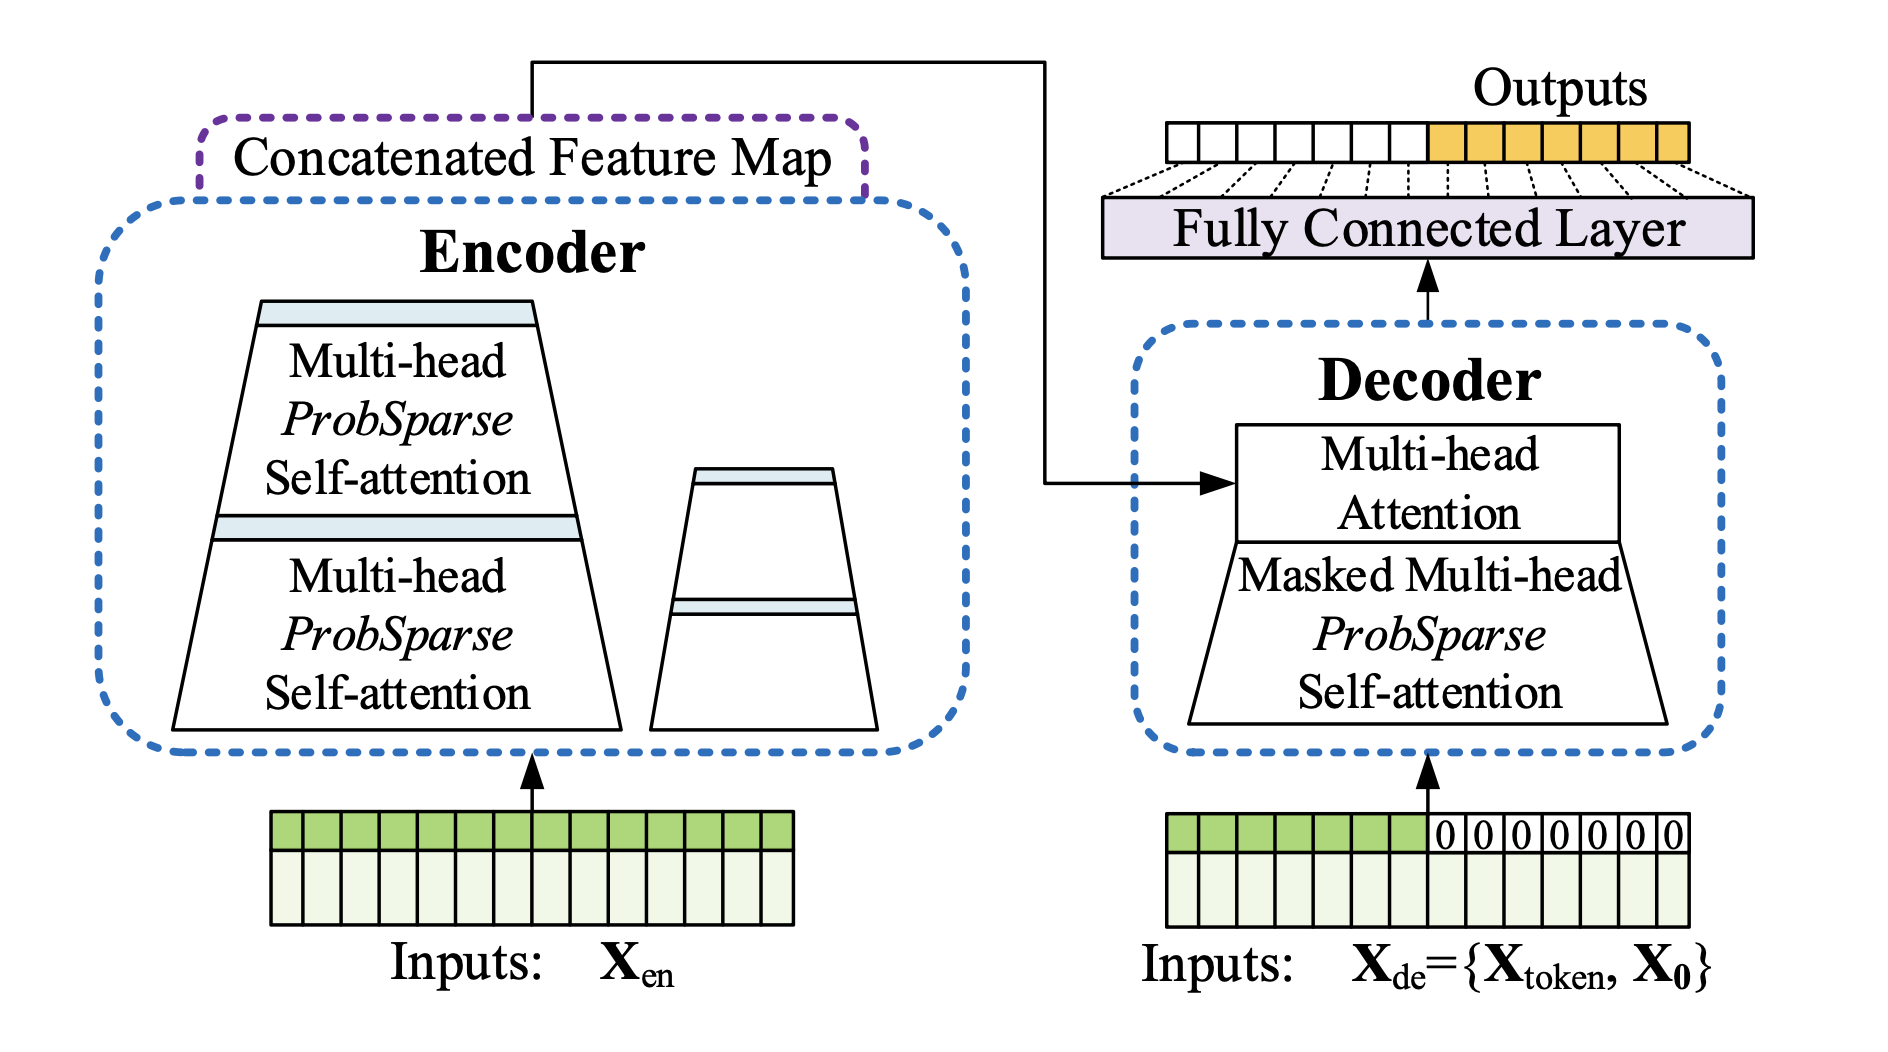

### ProbSparse Attention

The main idea of ProbSparse is that the canonical self-attention scores form a long-tail distribution, where the "active" queries lie in the "head" scores and "lazy" queries lie in the "tail" area. By "active" query we mean a query $q_i$ such that the dot-product $<q_i, k_i>$ contributes to the major attention, whereas a "lazy" query forms a dot-product which generates trivial attention. Here, and $q_i$ and $k_i$ are the i-th rows in Q and K attention matrices respectively.


Given the idea of "active" and "lazy" queries, the ProbSparse attention selects the "active" queries, and creates a reduced query matrix $Q_{reduced}$
which is used to calculate the attention weights in O(LlogL).

$$ProbSparseAttention(Q,K,V) = Softmax(\frac{Q_{reduce}K^T}{\sqrt d_k})V$$


The $Q_{reduce}$ matrix only selects the Top u "active" queries. Here, $u=c⋅logL_Q$ and c called the sampling factor hyperparameter for the ProbSparse attention.

**Query Sparsity Measurement**

Query Sparsity Measurement $M(q_i, K)$ is used for selecting the u "active" queries $q_i$ in Q to create $Q_{reduce}$. In theory, the dominant $<q_i, k_i>$ pairs encourage the "active" $q_i$ probability distribution away from the uniform distribution as can be seen in the figure below. Hence, the KL divergence between the actual queries distribution and the uniform distribution is used to define the sparsity measurement.



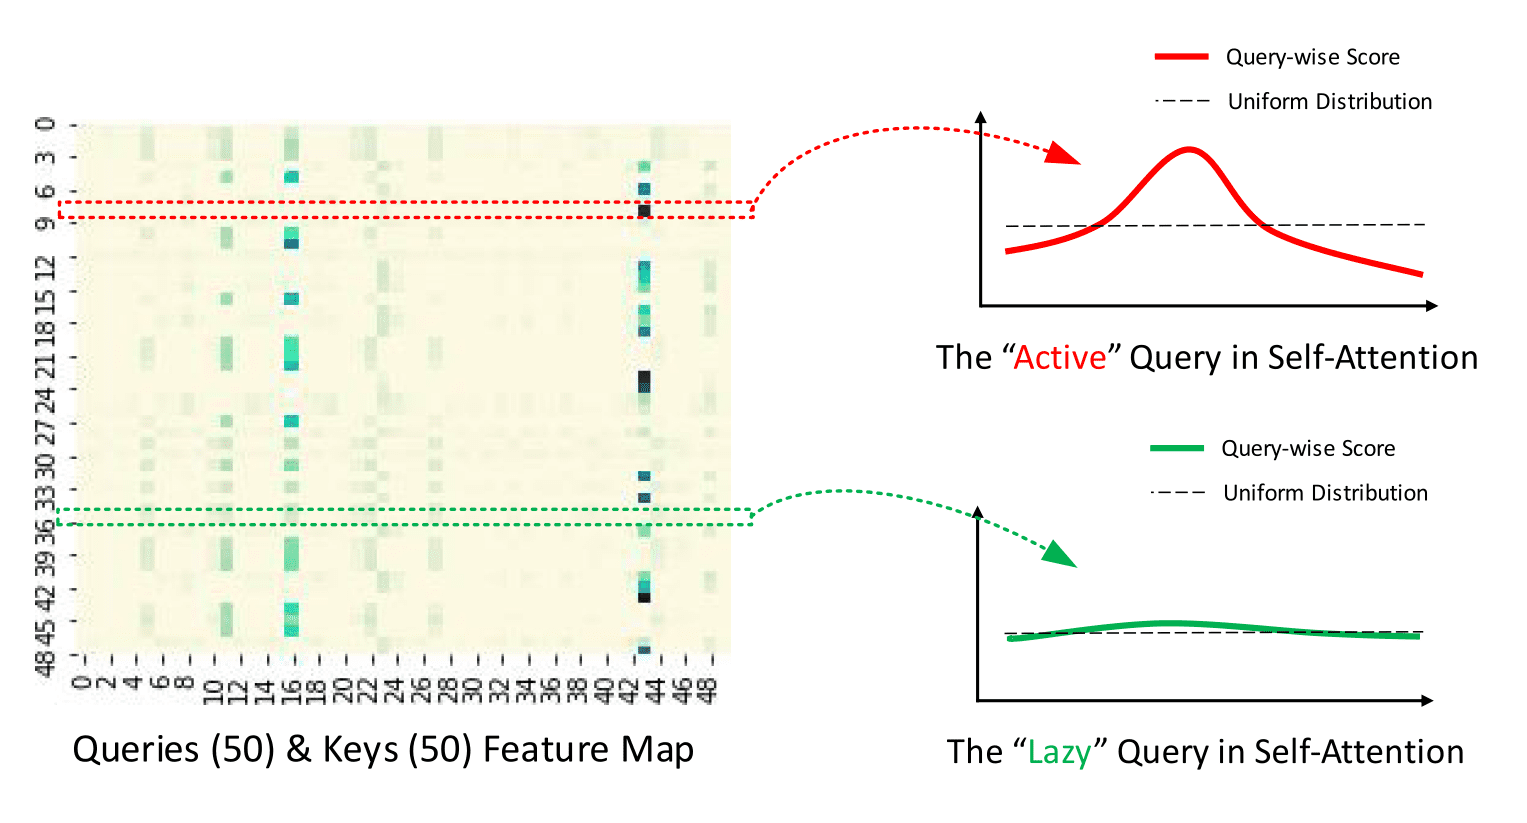

In practice, the measurement is defined as:

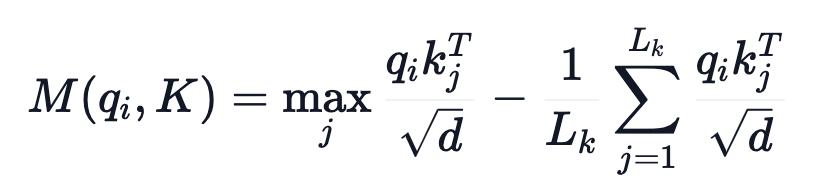

The important thing to understand here is when $M(q_i, K)$ is larger, the query $q_i$ should be in $Q_{reduce}$ and vice versa.




**Distilling**

Because of the ProbSparse self-attention, the encoder’s feature map has some redundancy that can be removed. Therefore, the distilling operation is used to reduce the input size between encoder layers into its half slice, thus in theory removing this redundancy. In practice, Informer's "distilling" operation just adds 1D convolution layers with max pooling between each of the encoder layers. Let $X_n$ be the output of the n-th encoder layer, the distilling operation is then defined as:

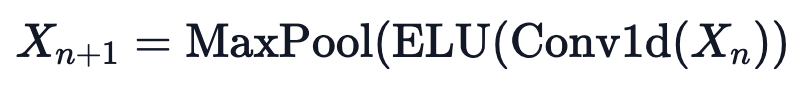

By reducing the input of each layer by two, we get a memory usage of $O(NLlogL)$ instead of $O(NL^2)$ where N is the number of encoder/decoder layers.

# Autoformer

Autoformer builds upon the traditional method of decomposing time series into seasonality and trend-cycle components. This is achieved through the incorporation of a Decomposition Layer, which enhances the model's ability to capture these components accurately. Moreover, Autoformer introduces an innovative auto-correlation mechanism that replaces the standard self-attention used in the vanilla transformer. This mechanism enables the model to utilize period-based dependencies in the attention, thus improving the overall performance.



**Decomposition of Time Series**

In time series analysis, decomposition is a method of breaking down a time series into three systematic components: trend-cycle, seasonal variation, and random fluctuations. The trend component represents the long-term direction of the time series, which can be increasing, decreasing, or stable over time. The seasonal component represents the recurring patterns that occur within the time series, such as yearly or quarterly cycles. Finally, the random (sometimes called "irregular") component represents the random noise in the data that cannot be explained by the trend or seasonal components.

Two main types of decomposition are additive and multiplicative decomposition, which are implemented in the great statsmodels library. By decomposing a time series into these components, we can better understand and model the underlying patterns in the data.

**Decomposition in Autoformer**

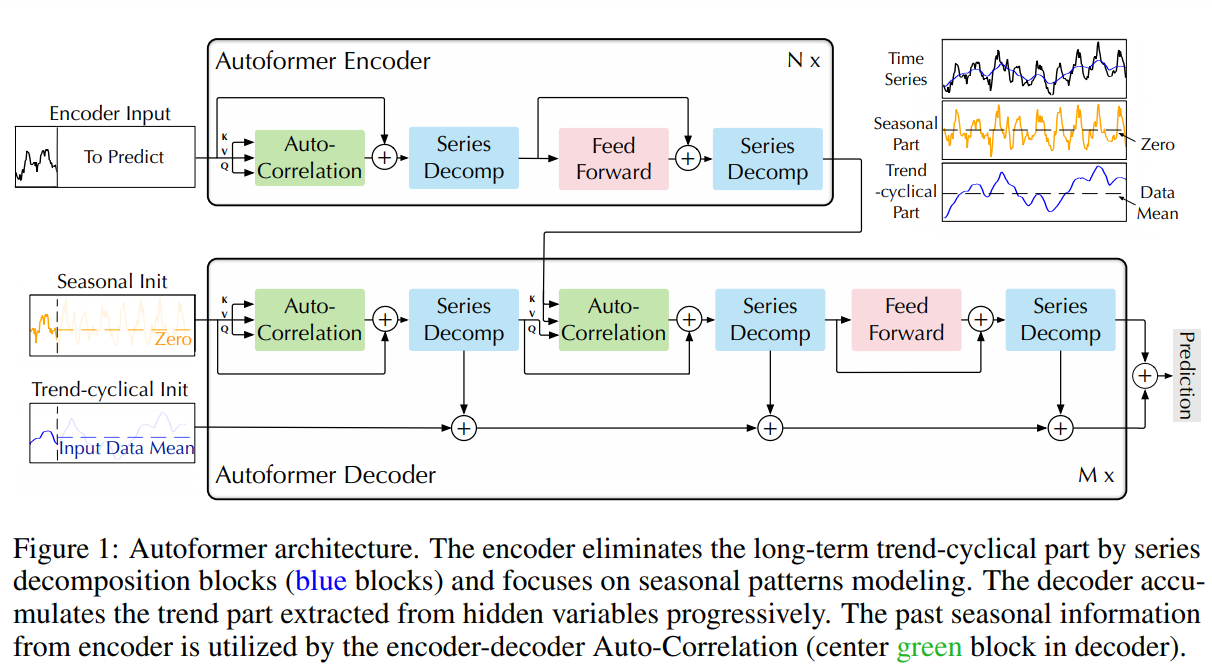

Autoformer incorporates a decomposition block as an inner operation of the model, as presented in the Autoformer's architecture above. As can be seen, the encoder and decoder use a decomposition block to aggregate the trend-cyclical part and extract the seasonal part from the series progressively. The concept of inner decomposition has demonstrated its usefulness since the publication of Autoformer.

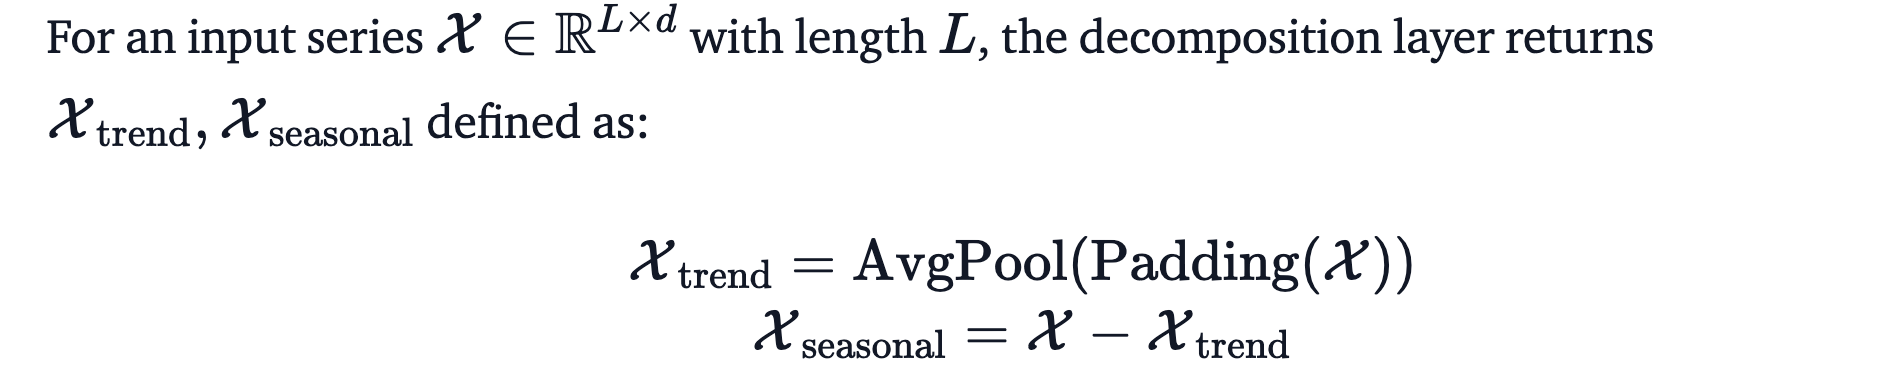

**Attention (Autocorrelation) Mechanism**

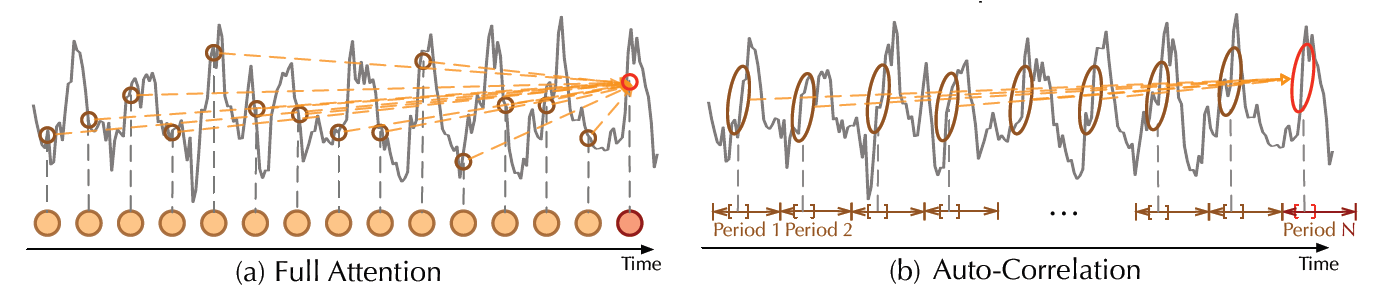

In addition to the decomposition layer, Autoformer employs a novel auto-correlation mechanism which replaces the self-attention seamlessly. In the vanilla Time Series Transformer, attention weights are computed in the time domain and point-wise aggregated. On the other hand, as can be seen in the figure above, Autoformer computes them in the frequency domain (using fast fourier transform) and aggregates them by time delay.

**Frequency Domain Attention**

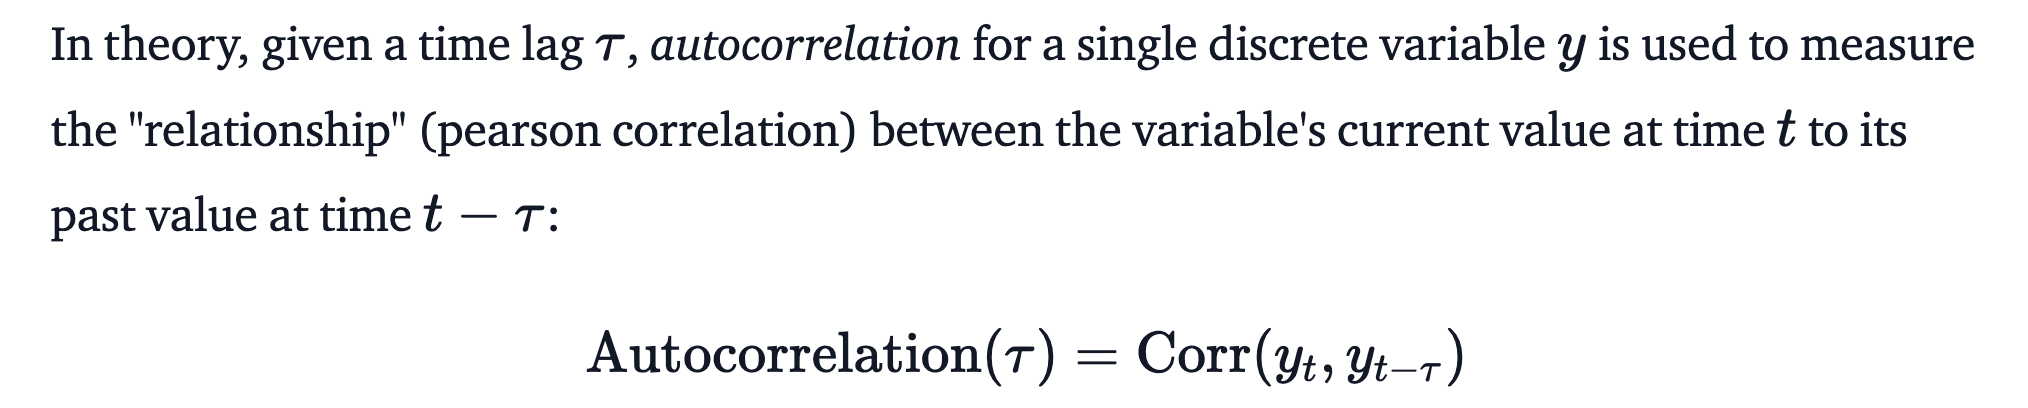

Using autocorrelation, Autoformer extracts frequency-based dependencies from the queries and keys, instead of the standard dot-product between them.

In practice, autocorrelation of the queries and keys for all lags is calculated at once by FFT. By doing so, the autocorrelation mechanism achieves $O(LlogL)$ (where L is the input time length), similar to Informer's ProbSparse attention. Note that the theory behind computing autocorrelation using FFT is based on the Wiener–Khinchin theorem.

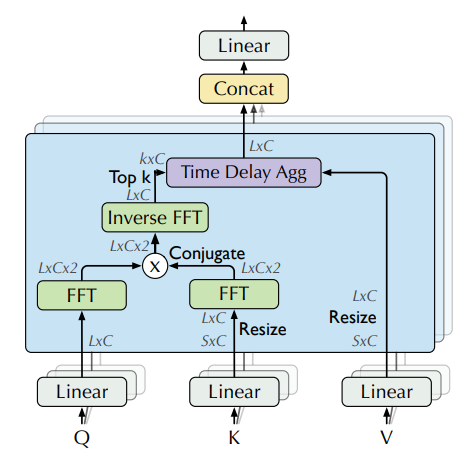

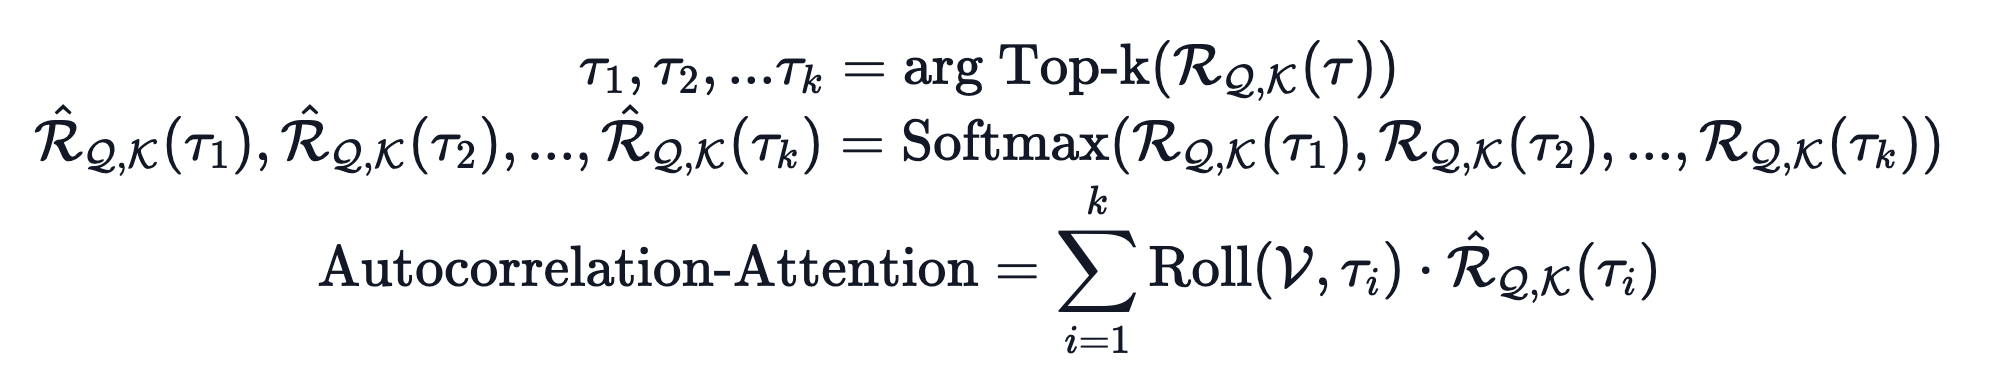

# FEDformer

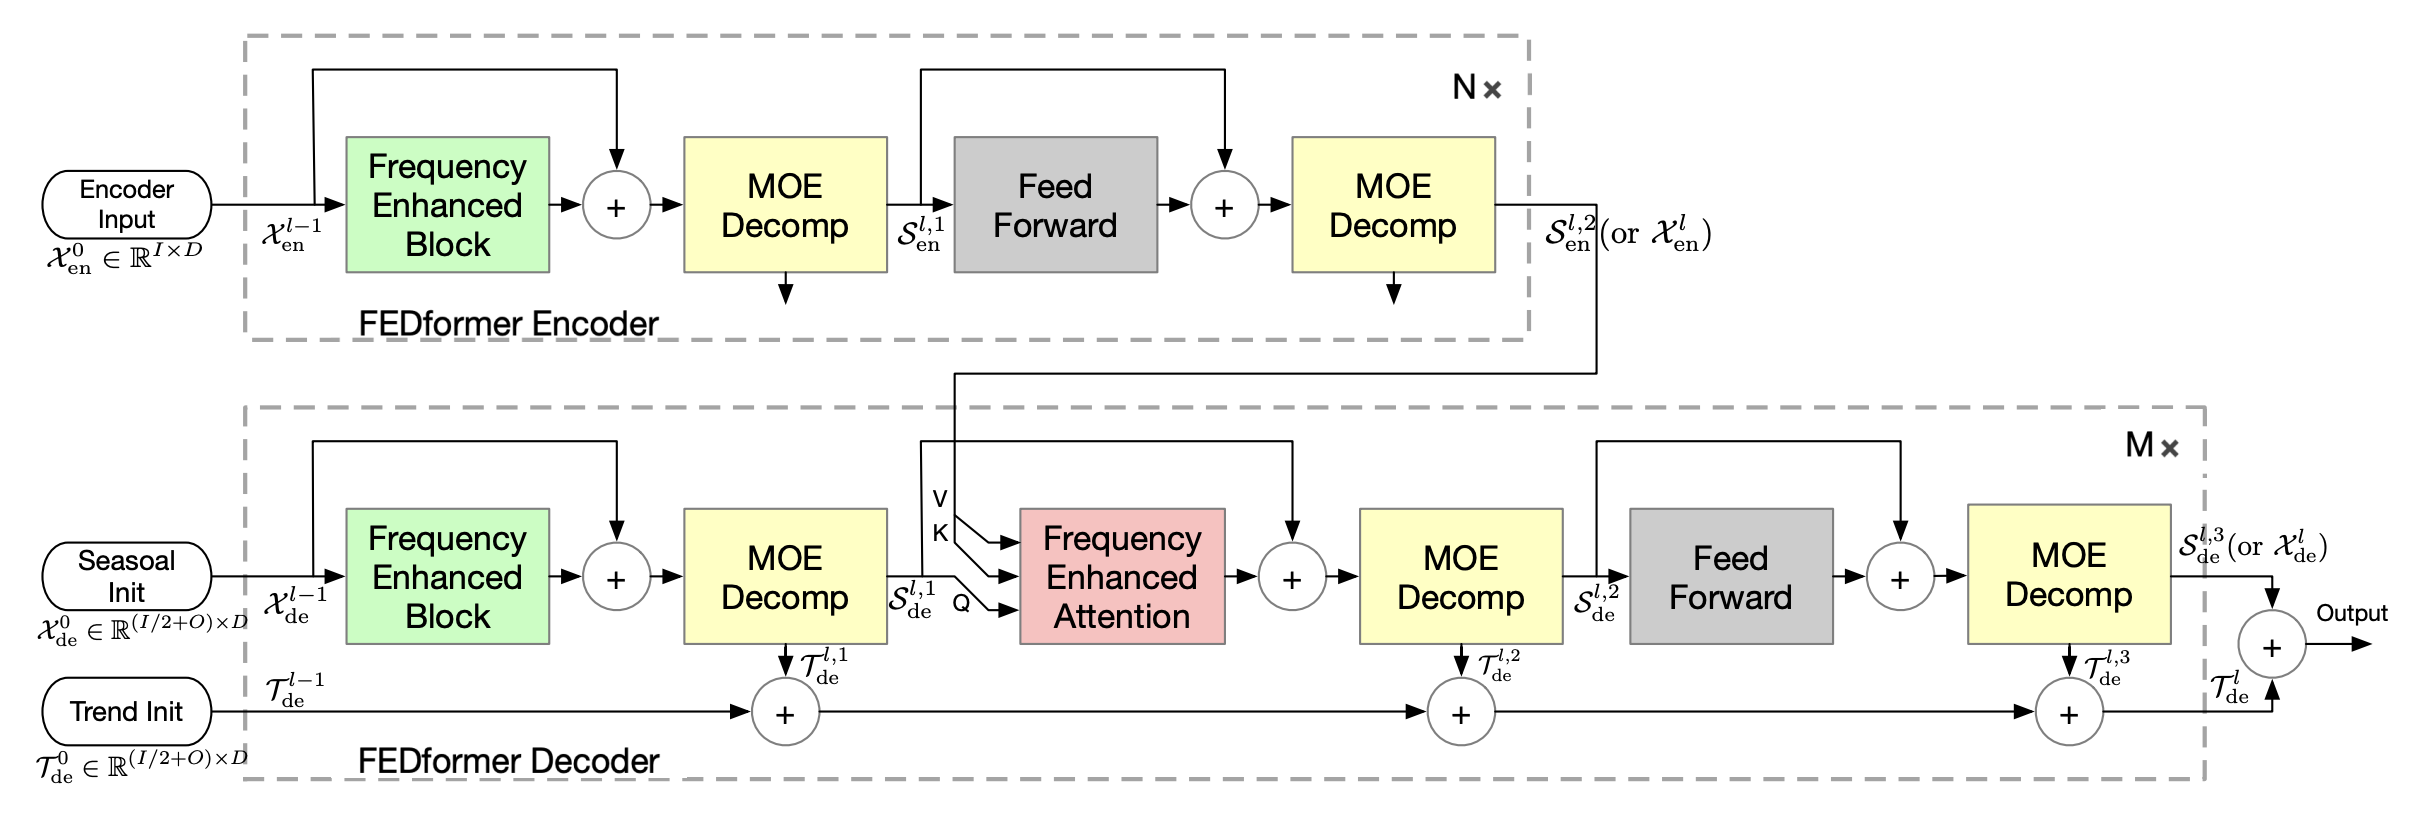

Main ideas:

IDEA 1) incorporate S-T decomposition

IDEA 2) combine Fourier Analysis with Transformer


Which subset of frequency components should be used by Fourier Analysis?

TS tend to have SPARSE representations on a basis, like Fourier basis → randomly select frequency components!

Contribution:
- propose Fourier enhanced blocks & Wavelet enhanced blocks
- by randomly selecting a fixed number of Fourier components, achieve linear computational complexity & memory cost

(1) FED ( Frequency Enhanced Block )

(2) FEA ( Frequency Enhanced Attention )

(3) MOEDcomp ( Mixture Of Experts Decomposition block )

Extracting trend can be hard with FIXED window average pooling → use MOEDecomp ( Mixture of Experts Decomposition block ) that contains a set of average filters with different sizes, to extract multiple trend components from the input signal

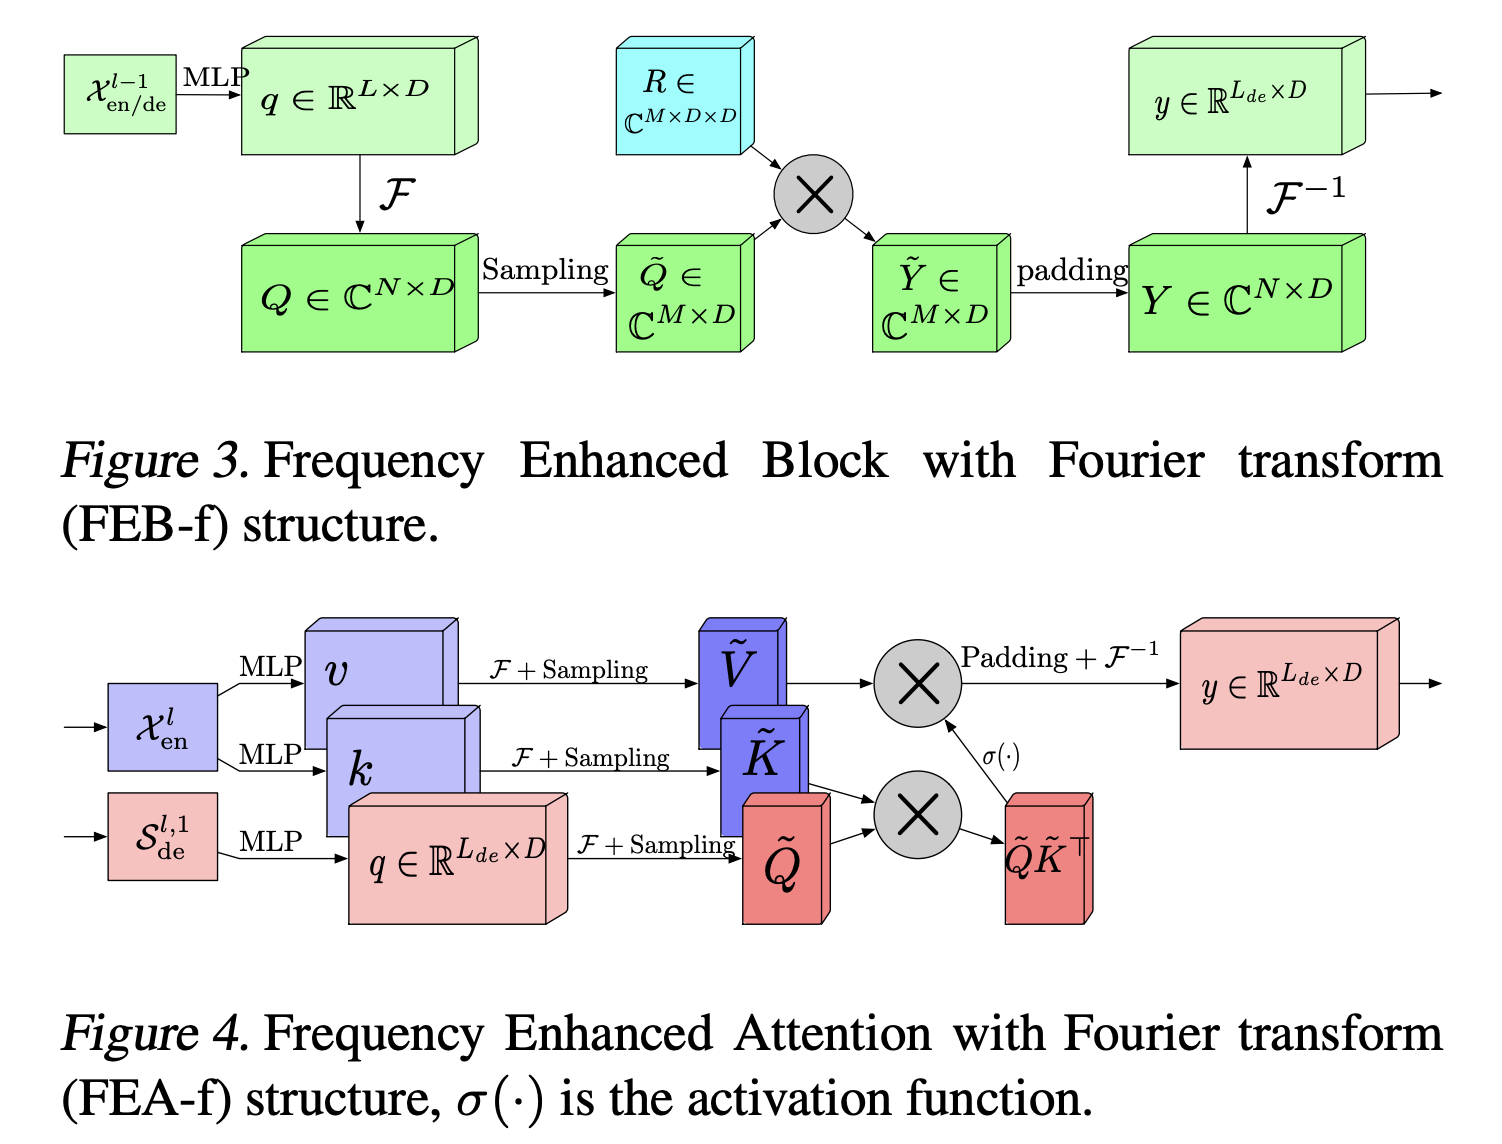

### Complexity analysis of Transformer-based models

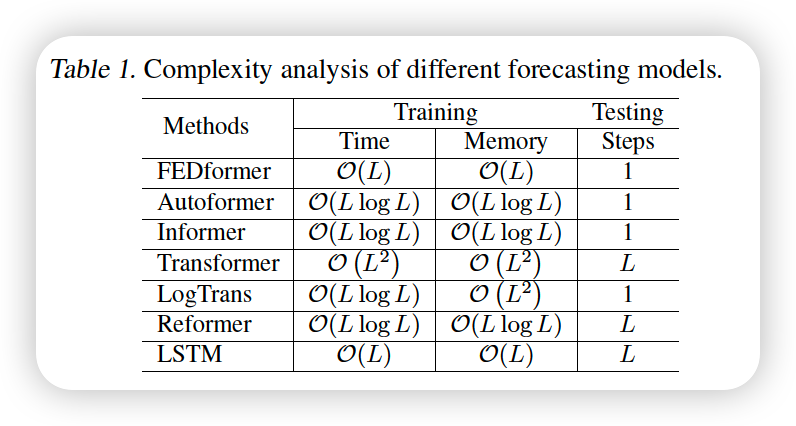

In [ ]:
!git clone https://github.com/MAZiqing/FEDformer.git

Cloning into 'FEDformer'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 194 (delta 60), reused 43 (delta 43), pack-reused 112 (from 1)
Receiving objects: 100% (194/194), 74.40 KiB | 3.72 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [ ]:
cd FEDformer

/content/FEDformer


## Handling dataset

In [ ]:
# класс для обращения к данным
class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='WeekDay', data_path='energy_consumption_hours.csv',
                 target='EnergyCons', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]

        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        print(df_raw.head())

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop('date', axis=1).values

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = s_end + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [ ]:
def data_provider(args, flag):
    timeenc = 0
    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Dataset_ETT_hour(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq
    )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last
    )
    return data_set, data_loader

In [ ]:
from utils.tools import EarlyStopping, adjust_learning_rate, visual
from utils.metrics import metric

from models import FEDformer, Autoformer, Informer, Transformer

## Class for experiment conduction

In [ ]:
class Experiment():
    def __init__(self, args):
        self.args = args
        self.device = torch.device('cuda:{}'.format(0))
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        model_dict = {
            'FEDformer': FEDformer,
            'Autoformer': Autoformer,
            'Transformer': Transformer,
            'Informer': Informer
        }
        model = model_dict[self.args.model].Model(self.args).float()
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = 0
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)

                total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)

                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                # encoder - decoder
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = 0
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                loss = criterion(outputs, batch_y)
                train_loss.append(loss.item())
                loss.backward()
                model_optim.step()

            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch + 1, self.args)

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))

        return self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = 0

                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()

                pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
                true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

                preds.append(pred)
                trues.append(true)

        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}, mape:{}'.format(mse, mae, mape))
        f = open("result.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}, mape:{}'.format(mse, mae, mape))
        f.write('\n')
        f.write('\n')
        f.close()

        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path + 'pred.npy', preds)
        np.save(folder_path + 'true.npy', trues)

        return


## Initialization of experiment parameters

In [ ]:
class Args():
    def __init__(self):
        self.is_training = 1
        self.task_id = 'test'
        self.model = 'Autoformer'

        # supplementary config for FEDformer model
        self.version = 'Fourier'
        self.mode_select = 'random'
        self.modes = 64
        self.L = 3
        self.base = 'legendre'
        self.cross_activation = 'tanh'

        # data loader
        self.data = 'energy_consumption_hours.csv'
        self.root_path = 'https://raw.githubusercontent.com/aromanenko/ATSF/main/data/'
        self.data_path = 'energy_consumption_hours.csv'
        self.features = 'WeekDay'
        self.target = 'EnergyCons'
        self.freq = 'h'
        self.detail_freq     = 'h'
        self.checkpoints = './checkpoints/'

        # forecasting task
        self.seq_len = 96
        self.label_len = 48
        self.pred_len = 96

        # model define
        self.enc_in = 7
        self.dec_in = 7
        self.c_out = 7
        self.d_model = 512
        self.n_heads = 8
        self.e_layers = 2
        self.d_layers = 1
        self.d_ff = 2048
        self.moving_avg = [24]
        self.factor = 1
        self.distil = True
        self.dropout = 0.05
        self.embed = 'timeF'
        self.activation = 'gelu'
        self.output_attention = False
        self.do_predict = False

        # optimization
        self.num_workers = 10
        self.itr = 1
        self.train_epochs = 10
        self.batch_size = 32
        self.patience = 3
        self.learning_rate = 0.0001
        self.des = 'test'
        self.loss = 'mse'
        self.lradj = 'type1'
        self.use_amp = False

        # GPU
        self.use_gpu = True
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0,1'


In [ ]:
args = Args()

In [ ]:
setting = '{}_{}_{}_modes{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.task_id,
            args.model,
            args.mode_select,
            args.modes,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des,
            1)

In [ ]:
exp = Experiment(args)

Autocorrelation used !
Autocorrelation used !
Autocorrelation used !
Autocorrelation used !


In [ ]:
exp.train(setting)

               Date  EnergyCons  Dev  WeekDay
0  2005-01-01 00:00        1290  -11        6
1      2005-1-1 1:0        1266  -12        6
2      2005-1-1 2:0        1273  -13        6
3      2005-1-1 3:0        1280  -14        6
4      2005-1-1 4:0        1293  -15        6


UnboundLocalError: cannot access local variable 'df_data' where it is not associated with a value

In [ ]:
exp.test(setting, test=1)

test 2785
loading model
test shape: (87, 32, 96, 7) (87, 32, 96, 7)
test shape: (2784, 96, 7) (2784, 96, 7)
mse:0.46762460470199585, mae:0.46466174721717834, mape:10.947725296020508
